In [1]:
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset

from torchvision import transforms, models, datasets
from torchsummary import summary

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from PIL import Image
%matplotlib inline
import cv2
from glob import glob
import numpy as np
import pandas as pd

In [3]:
from random import shuffle, seed
seed(10)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model = models.vgg16(pretrained=True).to(device)

In [6]:
summary(model, input_size=(3,244,244))

/Users/vanka/opt/anaconda3/envs/learn/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-_4mbk50o/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1, 128, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]         295,168
             ReLU-12          [-1, 256, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]         590,080
             ReLU-14          [-1, 256,

In [7]:
# !kaggle datasets download -d tongpython/cat-and-dog
# !unzip cat-and-dog.zip

In [8]:
train_data_dir = './data/training_set/training_set'
test_data_dir = './data/test_set/test_set'

In [9]:
class CatsDogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats[:500] + dogs[0:500]
        self.normalize = transforms.Normalize(
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]
                        )
        shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]
    
    def __len__(self): return len(self.fpaths)

    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:, :, ::-1])
        im = cv2.resize(im, (244, 244))
        im = torch.tensor(im/255)
        im = im.permute(2, 0, 1)
        im= self.normalize(im)
        return im.float().to(device), torch.tensor([target]).float().to(device)

In [10]:
data = CatsDogs(train_data_dir)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([0.])


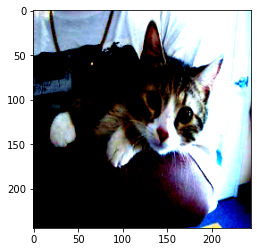

In [11]:
im, label = data[200]
plt.imshow(im.permute(1, 2, 0).cpu())
print(label)

In [12]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(
                            nn.Flatten(),
                            nn.Linear(512, 128),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(128, 1),
                            nn.Sigmoid()
                        )
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model.to(device), loss_fn, optimizer

In [13]:
model, criterion, optimizer = get_model()
summary(model, input_size=(3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1, 128, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]         295,168
             ReLU-12          [-1, 256, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]         590,080
             ReLU-14          [-1, 256,

In [14]:
def train_batch(x, y, model, optimizer, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [15]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [16]:
def get_data():
    train = CatsDogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
    val = CatsDogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
    return trn_dl, val_dl

In [17]:
trn_dl, val_dl = get_data()

In [18]:
model, loss_fn, optimizer = get_model()

In [19]:
train_losses, train_accuracies = [], []
val_accuracies = []

In [20]:
for epoch in range(5):
    print(f"epoch {epoch+1}/5")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses = np.array(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()
    
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)
    
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

epoch 1/5
epoch 2/5
epoch 3/5
epoch 4/5
epoch 5/5


/var/folders/s7/wjlwm8cj2jl8sxbd_t6klqj00000gn/T/ipykernel_25823/22244881.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


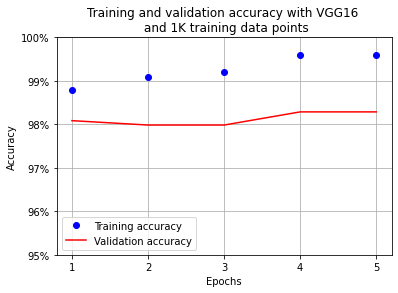

In [25]:
epochs = np.arange(5)+1
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')

plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with VGG16 \n and 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.95,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()